## Import library

In [34]:
import sys

MAIN_PATH = "/home/trduong/Data/interpretable_machine_learning/Source Code/my_work"


sys.path.insert(
    1,
    MAIN_PATH + '/lib'
)

sys.path.insert(
    1,
    MAIN_PATH + '/config'
)

import numpy as np
import pandas as pd
import logging
import incremental_ps_score_estimator as ipse
import math
import timeit
import utils
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import KFold
import experiment_config as ecf

import dowhy.datasets
import dowhy
from dowhy import CausalModel
import matplotlib.pyplot as plt

from econml.drlearner import ForestDRLearner, LinearDRLearner
from econml.metalearners import SLearner, XLearner, TLearner
from econml.ortho_forest import CausalTree, ContinuousTreatmentOrthoForest, DiscreteTreatmentOrthoForest
from econml.dml import ForestDMLCateEstimator, LinearDMLCateEstimator, SparseLinearDMLCateEstimator
from econml.inference import BootstrapInference
from econml.sklearn_extensions.linear_model import WeightedLasso, WeightedLassoCV

### Import sklearn
from scipy.stats import sem
import scipy.stats as st
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import explained_variance_score, mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.linear_model import LassoCV, ElasticNetCV
from bartpy.sklearnmodel import SklearnModel


from zepid.causal.doublyrobust import TMLE
from cforest.forest import CausalForest


## Load data

In [35]:
figure_path = "/home/dtd/Documents/PhD_Life/Source Code/my_work/figure"

In [36]:
file_path = "https://msalicedatapublic.blob.core.windows.net/datasets/Pricing/pricing_sample.csv"
train_data = pd.read_csv(file_path)

In [37]:
train_data.price.value_counts()

1.0    4346
0.8    3089
0.9    2565
Name: price, dtype: int64

In [38]:
train_data.shape

OSError: [Errno 12] Cannot allocate memory

(10000, 11)

In [39]:
train_data['treatment'] = np.where(train_data['price'] == 1, 1, 0)
train_data['price'] = np.where(train_data['price'] == 1, 1, 0.85)

In [40]:
train_data.price.value_counts()

0.85    5654
1.00    4346
Name: price, dtype: int64

In [41]:
train_data.head()

,account_age,age,avg_hours,days_visited,friends_count,has_membership,is_US,songs_purchased,income,price,demand,treatment
0,3,53,1.834234,2,8,1,1,4.903237,0.960863,1.00,3.917117,1
1,5,54,7.171411,7,9,0,1,3.330161,0.732487,1.00,11.585706,1
2,3,33,5.351920,6,9,0,1,3.036203,1.130937,1.00,24.675960,1
3,2,34,6.723551,0,8,0,1,7.911926,0.929197,1.00,6.361776,1
4,4,30,2.448247,5,8,1,0,7.148967,0.533527,0.85,12.624123,0


## Features engineering

In [42]:
outcome = "demand"
treatment = "treatment"
col = list(train_data.columns)
col.remove("price")
print(col)

cov = col[:]
cov.remove(treatment)
cov.remove(outcome)
cov.remove('income')
print(cov)

features = col[:]
features.remove(outcome)

print(features)

['account_age', 'age', 'avg_hours', 'days_visited', 'friends_count', 'has_membership', 'is_US', 'songs_purchased', 'income', 'demand', 'treatment']
['account_age', 'age', 'avg_hours', 'days_visited', 'friends_count', 'has_membership', 'is_US', 'songs_purchased']
['account_age', 'age', 'avg_hours', 'days_visited', 'friends_count', 'has_membership', 'is_US', 'songs_purchased', 'income', 'treatment']


In [43]:
result_dic = {
    'ortho_train':0,
    'ortho_test':0,
    'linear_dr_train':0,
    'linear_dr_test':0,
    'forest_dr_train':0,
    'forest_dr_test':0,
    'incremental_train':0,
    'incremental_test':0,
    'causal_forest_train':0,
    'causal_forest_test':0,
    'tmle_train':0,
    'tmle_test':0,
    'knn_train':0,
    'knn_test':0,
    'ps_train':0,
    'ps_test':0,
    'lr_train':0,
    'lr_test':0,
    'bart_train':0,
    'bart_test':0,
}


## Synthesis function

In [44]:
# Define underlying treatment effect function given DGP
def gamma_fn(X):
    return -3 - 14 * (X["income"] < 1)

def beta_fn(X):
    return 20 + 0.5 * (X["avg_hours"]) + 5 * (X["days_visited"] > 4)

def demand_fn(data, T):
    Y = gamma_fn(data) * T + beta_fn(data)
    return Y

def true_te(x, n, stats):
    if x < 1:
        subdata = train_data[train_data["income"] < 1].sample(n=n, replace=True)
    else:
        subdata = train_data[train_data["income"] >= 1].sample(n=n, replace=True)
    te_array = subdata["price"] * gamma_fn(subdata) / (subdata["demand"])
    if stats == "mean":
        return np.mean(te_array)
    elif stats == "median":
        return np.median(te_array)
    elif isinstance(stats, int):
        return np.percentile(te_array, stats)

## Estimation effect with incremental propensity score

### Estimation effect in train-test

In [45]:
train, test = train_test_split(train_data, test_size=0.2, random_state = 1)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
## Fit treatment
model_t = LogisticRegression()
model_t.fit(train[cov], train[treatment])

train['p1'] = model_t.predict_proba(train[cov])[:,1]
train['p0'] = 1 - train['p1']

train["prediction"] = np.where(train["p1"] >= 0.5, 1, 0)
acc = accuracy_score(train["prediction"], train["treatment"])
print("Accuracy score of train data {}".format(acc))

## Fit outcome
model_y = GradientBoostingRegressor(random_state=0, n_estimators = 5000)
model_y.fit(train[features], train[outcome])


Accuracy score of train data 0.56625


GradientBoostingRegressor(n_estimators=5000, random_state=0)

In [46]:
delta = 2.0

te_array = test["price"] * gamma_fn(test) / (test["demand"])
true_effect_test = np.mean(te_array)

te_array = train["price"] * gamma_fn(train) / (train["demand"])
true_effect_train = np.mean(te_array)

influence = ipse.influence_function(train, treatment, cov, outcome, features, delta, model_y, model_t)
means_incre_train, stds_incre = np.mean(influence, axis=0), sem(influence, axis=0)

influence = ipse.influence_function(test, treatment, cov, outcome, features, delta, model_y, model_t)
means_incre_test, stds_incre = np.mean(influence, axis=0), sem(influence, axis=0)

origin_mae_train = utils.abs_ate(true_effect_train, means_incre_train)
origin_mae_test = utils.abs_ate(true_effect_test, means_incre_test)


## Optimization with single delta

In [47]:
def incre_ps(delta, data):
    q1 = (delta * data['p1']) / (delta * data['p1'] + data['p0'])
    q1 = tf.math.abs(q1)
    a0 = (1-q1)*data['w0']*(data['cf0'] - data[outcome])
    a1 = q1*data['w1']*(data['cf1'] - data[outcome])    
    influence = a1 - a0
    return tf.reduce_mean(influence), influence

def optimization(train, test, true_effect):
    threhold = tf.constant([0.0001])
    delta = tf.Variable(np.random.randint(low=1, high=100, size=1), 
                        trainable = True, 
                        dtype = tf.float32)
    delta_seq = []
    losses = []
    losses_test = []
    effects_train = []
    effects_test = []
    influences_train = []
    influences_test = []
    for i in tqdm(range(100000)):
        with tf.GradientTape() as tape:
            mu_influence_train, influence_train = incre_ps(delta, train)
            mu_influence_test, influence_test = incre_ps(delta, test)
            loss = tf.math.abs(true_effect - mu_influence_train)
            loss_test = tf.math.abs(true_effect - mu_influence_test)
            d_delta = tape.gradient(loss, delta)
            opt = tf.keras.optimizers.Adam(learning_rate=0.01)
            opt.apply_gradients(zip([d_delta], [delta]))
            ## early stopping 
            if tf.math.less(loss, threhold):
                print("The performance reach MAE: 0.001. Cancelling the training at step {}".format(i))
                break
            delta_seq.append(delta.numpy())
            losses.append(loss.numpy())
            losses_test.append(loss_test.numpy())
            effects_train.append(mu_influence_train.numpy())
            effects_test.append(mu_influence_test.numpy())
            influences_train.append(influence_train.numpy())
            influences_test.append(influence_test.numpy())
        if i % 1000 == 0:
            print("Epoch {}. Loss {:.4f}".format(i, loss))
    print("Loss {:.3f}".format(loss))
    return delta, delta_seq, losses, losses_test, influences_train, influences_test

In [48]:
te_array = train["price"] * gamma_fn(train) / (train["demand"])
true_effect = np.mean(te_array)
delta, delta_seq, losses, losses_test, influences_train, influences_test = optimization(train, test, true_effect)

  0%|          | 23/100000 [00:00<15:20, 108.64it/s]

Epoch 0. Loss 1.1612


  1%|          | 1014/100000 [00:08<12:52, 128.19it/s]

Epoch 1000. Loss 1.1590


  2%|▏         | 2025/100000 [00:15<12:43, 128.30it/s]

Epoch 2000. Loss 1.1562


  3%|▎         | 3026/100000 [00:23<12:16, 131.67it/s]

Epoch 3000. Loss 1.1525


  4%|▍         | 4023/100000 [00:31<13:25, 119.18it/s]

Epoch 4000. Loss 1.1472


  5%|▌         | 5021/100000 [00:39<11:55, 132.81it/s]

Epoch 5000. Loss 1.1392


  6%|▌         | 6015/100000 [00:46<11:56, 131.20it/s]

Epoch 6000. Loss 1.1260


  7%|▋         | 7025/100000 [00:54<12:28, 124.22it/s]

Epoch 7000. Loss 1.0993


  8%|▊         | 8014/100000 [01:02<12:34, 121.84it/s]

Epoch 8000. Loss 1.0181


  9%|▉         | 9021/100000 [01:11<12:28, 121.49it/s]

Epoch 9000. Loss 0.0051


 10%|█         | 10023/100000 [01:19<11:43, 127.87it/s]

Epoch 10000. Loss 0.0051


 11%|█         | 11014/100000 [01:27<11:20, 130.76it/s]

Epoch 11000. Loss 0.0051


 12%|█▏        | 12023/100000 [01:35<11:34, 126.76it/s]

Epoch 12000. Loss 0.0051


 13%|█▎        | 13023/100000 [01:43<11:44, 123.45it/s]

Epoch 13000. Loss 0.0051


 14%|█▍        | 14018/100000 [01:51<11:14, 127.53it/s]

Epoch 14000. Loss 0.0051


 15%|█▌        | 15024/100000 [01:58<11:14, 125.90it/s]

Epoch 15000. Loss 0.0051


 16%|█▌        | 16015/100000 [02:06<10:39, 131.42it/s]

Epoch 16000. Loss 0.0051


 17%|█▋        | 17024/100000 [02:14<11:22, 121.66it/s]

Epoch 17000. Loss 0.0051


 18%|█▊        | 18021/100000 [02:22<10:03, 135.84it/s]

Epoch 18000. Loss 0.0051


 19%|█▉        | 19024/100000 [02:29<10:10, 132.70it/s]

Epoch 19000. Loss 0.0051


 20%|██        | 20016/100000 [02:37<10:05, 132.05it/s]

Epoch 20000. Loss 0.0051


 21%|██        | 21015/100000 [02:45<10:18, 127.81it/s]

Epoch 21000. Loss 0.0051


 22%|██▏       | 22017/100000 [02:52<09:42, 133.85it/s]

Epoch 22000. Loss 0.0051


 23%|██▎       | 23017/100000 [03:00<10:49, 118.51it/s]

Epoch 23000. Loss 0.0051


 24%|██▍       | 24021/100000 [03:08<09:44, 130.02it/s]

Epoch 24000. Loss 0.0051


 25%|██▌       | 25026/100000 [03:16<09:24, 132.70it/s]

Epoch 25000. Loss 0.0051


 26%|██▌       | 26021/100000 [03:24<09:52, 124.88it/s]

Epoch 26000. Loss 0.0051


 27%|██▋       | 27017/100000 [03:31<09:29, 128.10it/s]

Epoch 27000. Loss 0.0051


 28%|██▊       | 28018/100000 [03:40<09:27, 126.83it/s]

Epoch 28000. Loss 0.0051


 29%|██▉       | 29021/100000 [03:47<08:59, 131.48it/s]

Epoch 29000. Loss 0.0051


 30%|███       | 30018/100000 [03:55<08:53, 131.08it/s]

Epoch 30000. Loss 0.0051


 31%|███       | 31025/100000 [04:02<08:31, 134.80it/s]

Epoch 31000. Loss 0.0051


 32%|███▏      | 32019/100000 [04:10<08:15, 137.21it/s]

Epoch 32000. Loss 0.0051


 33%|███▎      | 33015/100000 [04:17<09:06, 122.54it/s]

Epoch 33000. Loss 0.0051


 34%|███▍      | 34022/100000 [04:25<08:07, 135.40it/s]

Epoch 34000. Loss 0.0051


 35%|███▌      | 35016/100000 [04:33<08:00, 135.18it/s]

Epoch 35000. Loss 0.0051


 36%|███▌      | 36018/100000 [04:40<08:40, 122.95it/s]

Epoch 36000. Loss 0.0051


 37%|███▋      | 37016/100000 [04:49<08:38, 121.55it/s]

Epoch 37000. Loss 0.0051


 38%|███▊      | 38017/100000 [04:57<08:18, 124.37it/s]

Epoch 38000. Loss 0.0051


 39%|███▉      | 39012/100000 [05:04<08:21, 121.53it/s]

Epoch 39000. Loss 0.0051


 40%|████      | 40023/100000 [05:12<07:22, 135.47it/s]

Epoch 40000. Loss 0.0051


 41%|████      | 41024/100000 [05:20<07:50, 125.43it/s]

Epoch 41000. Loss 0.0051


 42%|████▏     | 42026/100000 [05:28<07:28, 129.12it/s]

Epoch 42000. Loss 0.0051


 43%|████▎     | 43023/100000 [05:36<07:18, 129.85it/s]

Epoch 43000. Loss 0.0051


 44%|████▍     | 44016/100000 [05:43<07:09, 130.26it/s]

Epoch 44000. Loss 0.0051


 45%|████▌     | 45016/100000 [05:51<06:48, 134.64it/s]

Epoch 45000. Loss 0.0051


 46%|████▌     | 46018/100000 [05:58<06:53, 130.48it/s]

Epoch 46000. Loss 0.0051


 47%|████▋     | 47026/100000 [06:06<06:34, 134.44it/s]

Epoch 47000. Loss 0.0051


 48%|████▊     | 48020/100000 [06:13<06:34, 131.69it/s]

Epoch 48000. Loss 0.0051


 49%|████▉     | 49016/100000 [06:21<06:06, 139.12it/s]

Epoch 49000. Loss 0.0051


 50%|█████     | 50026/100000 [06:28<06:09, 135.27it/s]

Epoch 50000. Loss 0.0051


 51%|█████     | 51024/100000 [06:36<06:28, 126.10it/s]

Epoch 51000. Loss 0.0051


 52%|█████▏    | 52017/100000 [06:43<05:53, 135.81it/s]

Epoch 52000. Loss 0.0051


 53%|█████▎    | 53025/100000 [06:51<05:43, 136.64it/s]

Epoch 53000. Loss 0.0051


 54%|█████▍    | 54021/100000 [06:59<06:17, 121.68it/s]

Epoch 54000. Loss 0.0051


 55%|█████▌    | 55020/100000 [07:06<05:25, 138.16it/s]

Epoch 55000. Loss 0.0051


 56%|█████▌    | 56024/100000 [07:14<05:46, 126.87it/s]

Epoch 56000. Loss 0.0051


 57%|█████▋    | 57022/100000 [07:22<05:47, 123.69it/s]

Epoch 57000. Loss 0.0051


 58%|█████▊    | 58026/100000 [07:30<05:07, 136.53it/s]

Epoch 58000. Loss 0.0051


 59%|█████▉    | 59020/100000 [07:37<04:59, 136.64it/s]

Epoch 59000. Loss 0.0051


 60%|██████    | 60014/100000 [07:45<05:05, 130.75it/s]

Epoch 60000. Loss 0.0051


 61%|██████    | 61022/100000 [07:52<05:14, 123.74it/s]

Epoch 61000. Loss 0.0051


 62%|██████▏   | 62019/100000 [08:00<04:38, 136.51it/s]

Epoch 62000. Loss 0.0051


 63%|██████▎   | 63022/100000 [08:08<05:02, 122.30it/s]

Epoch 63000. Loss 0.0051


 64%|██████▍   | 64023/100000 [08:16<04:52, 123.03it/s]

Epoch 64000. Loss 0.0051


 65%|██████▌   | 65022/100000 [08:24<04:22, 133.39it/s]

Epoch 65000. Loss 0.0051


 66%|██████▌   | 66025/100000 [08:32<04:09, 136.05it/s]

Epoch 66000. Loss 0.0051


 67%|██████▋   | 67017/100000 [08:39<04:09, 132.27it/s]

Epoch 67000. Loss 0.0051


 68%|██████▊   | 68025/100000 [08:47<03:56, 135.02it/s]

Epoch 68000. Loss 0.0051


 69%|██████▉   | 69019/100000 [08:54<03:54, 131.95it/s]

Epoch 69000. Loss 0.0051


 70%|███████   | 70026/100000 [09:02<03:42, 135.00it/s]

Epoch 70000. Loss 0.0051


 71%|███████   | 71016/100000 [09:09<03:50, 125.69it/s]

Epoch 71000. Loss 0.0051


 72%|███████▏  | 72027/100000 [09:17<03:24, 136.51it/s]

Epoch 72000. Loss 0.0051


 73%|███████▎  | 73021/100000 [09:24<03:18, 136.01it/s]

Epoch 73000. Loss 0.0051


 74%|███████▍  | 74015/100000 [09:32<03:09, 137.13it/s]

Epoch 74000. Loss 0.0051


 75%|███████▌  | 75023/100000 [09:39<03:01, 137.48it/s]

Epoch 75000. Loss 0.0051


 76%|███████▌  | 76021/100000 [09:47<03:00, 132.67it/s]

Epoch 76000. Loss 0.0051


 77%|███████▋  | 77024/100000 [09:55<03:05, 123.86it/s]

Epoch 77000. Loss 0.0051


 78%|███████▊  | 78015/100000 [10:02<02:40, 136.82it/s]

Epoch 78000. Loss 0.0051


 79%|███████▉  | 79023/100000 [10:10<02:36, 133.67it/s]

Epoch 79000. Loss 0.0051


 80%|████████  | 80017/100000 [10:17<02:26, 136.09it/s]

Epoch 80000. Loss 0.0051


 81%|████████  | 81025/100000 [10:24<02:19, 135.91it/s]

Epoch 81000. Loss 0.0051


 82%|████████▏ | 82024/100000 [10:32<02:15, 133.03it/s]

Epoch 82000. Loss 0.0051


 83%|████████▎ | 83013/100000 [10:39<02:09, 131.34it/s]

Epoch 83000. Loss 0.0051


 84%|████████▍ | 84024/100000 [10:47<02:07, 125.12it/s]

Epoch 84000. Loss 0.0051


 85%|████████▌ | 85021/100000 [10:55<02:00, 123.86it/s]

Epoch 85000. Loss 0.0051


 86%|████████▌ | 86012/100000 [11:03<01:52, 124.87it/s]

Epoch 86000. Loss 0.0051


 87%|████████▋ | 87021/100000 [11:11<01:39, 130.06it/s]

Epoch 87000. Loss 0.0051


 88%|████████▊ | 88022/100000 [11:19<01:32, 129.10it/s]

Epoch 88000. Loss 0.0051


 89%|████████▉ | 89026/100000 [11:26<01:23, 131.13it/s]

Epoch 89000. Loss 0.0051


 90%|█████████ | 90025/100000 [11:34<01:15, 132.62it/s]

Epoch 90000. Loss 0.0051


 91%|█████████ | 91019/100000 [11:41<01:07, 133.03it/s]

Epoch 91000. Loss 0.0051


 92%|█████████▏| 92019/100000 [11:49<00:59, 133.58it/s]

Epoch 92000. Loss 0.0051


 93%|█████████▎| 93027/100000 [11:56<00:52, 132.88it/s]

Epoch 93000. Loss 0.0051


 94%|█████████▍| 94019/100000 [12:04<00:45, 131.28it/s]

Epoch 94000. Loss 0.0051


 95%|█████████▌| 95028/100000 [12:11<00:36, 135.28it/s]

Epoch 95000. Loss 0.0051


 96%|█████████▌| 96022/100000 [12:19<00:29, 134.41it/s]

Epoch 96000. Loss 0.0051


 97%|█████████▋| 97016/100000 [12:26<00:22, 135.01it/s]

Epoch 97000. Loss 0.0051


 98%|█████████▊| 98024/100000 [12:34<00:14, 133.84it/s]

Epoch 98000. Loss 0.0051


 99%|█████████▉| 99016/100000 [12:41<00:07, 134.09it/s]

Epoch 99000. Loss 0.0051


100%|██████████| 100000/100000 [12:49<00:00, 130.00it/s]


Loss 0.004


In [49]:
losses[-1]

0.0037481189

In [50]:
te_array = test["price"] * gamma_fn(test) / (test["demand"])
true_effect_test = np.mean(te_array)

te_array = train["price"] * gamma_fn(train) / (train["demand"])
true_effect_train = np.mean(te_array)

mean_train = np.mean(influences_train[-1])
mean_test = np.mean(influences_test[-1])

optimal_mae_train = utils.abs_ate(true_effect_train, mean_train)
optimal_mae_test = utils.abs_ate(true_effect_test, mean_test)

In [51]:
result_dic['incremental_train'] = optimal_mae_train
result_dic['incremental_test'] = optimal_mae_test

In [52]:
delta

<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.01732158], dtype=float32)>

## Conclusion

In [53]:
print("Before Optimization")
print("MAE on training {} and testing {}".format(origin_mae_train, origin_mae_test))
print("After Optimization")
print("MAE on training {} and testing {}".format(optimal_mae_train, optimal_mae_test))


Before Optimization
MAE on training 0.7041575883204577 and testing 0.7055153685320681
After Optimization
MAE on training 0.0037482127635416473 and testing 0.05208216005466482


## Confidence interval

In [54]:
lowers_train, uppers_train = [], []
lowers_test, uppers_test = [], []
means_train, means_test = [], []

for i in tqdm(range(len(delta_seq))):

    mean_train, mean_test = np.mean(influences_train[i]), np.mean(influences_test[i])
    stds_incre_train, stds_incre_test = sem(influences_train[i], axis=0), sem(influences_test[i], axis=0)

    lower_train, upper_train = st.t.interval(0.90, 
                                         len(influences_train[i])-1, 
                                         loc=mean_train, 
                                         scale=stds_incre_train)
    lower_test, upper_test = st.t.interval(0.90, 
                                             len(influences_test[i])-1, 
                                             loc=mean_test, 
                                             scale=stds_incre_test)
    

    lowers_train.append(lower_train)
    uppers_train.append(upper_train)
    lowers_test.append(lower_test)
    uppers_test.append(upper_test)
    means_train.append(mean_train)
    means_test.append(mean_test)

100%|██████████| 100000/100000 [01:34<00:00, 1052.69it/s]


In [55]:
len(uppers_train), len(lowers_train), len(delta_seq), len(means_train)

OSError: [Errno 12] Cannot allocate memory

(100000, 100000, 100000, 100000)

In [56]:
lowers_train = np.array(lowers_train)
uppers_train = np.array(uppers_train)
delta_seq = np.array(delta_seq)

In [57]:
lowers_train[0], uppers_train[0]

OSError: [Errno 12] Cannot allocate memory

(-2.1581401250099073, -2.0725775339866748)

In [58]:
delta_seq = delta_seq.reshape(-1)

In [59]:
delta_seq[-1]

0.017321583

In [67]:
# lowers_train.shape, uppers_train.shape, delta_seq.shape

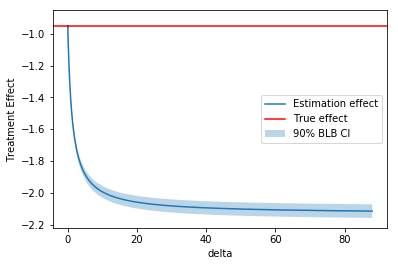

In [68]:
fig = plt.figure()
plt.plot(delta_seq, means_train, label='Estimation effect')
plt.axhline(y=true_effect_train, color='r', linestyle='-', label = "True effect")
plt.fill_between(delta_seq, lowers_train, uppers_train, label="90% BLB CI", alpha=0.3)
plt.ylabel("Treatment Effect")
plt.xlabel("delta")
# plt.title("The changes of effects depending on delta")
plt.legend()
plt.show()
fig.savefig(ecf.FIGURE_PATH + '/demand_train.png')


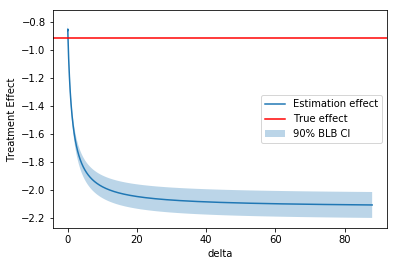

In [69]:
fig = plt.figure()
plt.plot(delta_seq, means_test, label='Estimation effect')
plt.axhline(y=true_effect_test, color='r', linestyle='-', label = "True effect")
plt.fill_between(delta_seq, lowers_test, uppers_test, label="90% BLB CI", alpha=0.3)
plt.ylabel("Treatment Effect")
plt.xlabel("delta")
# plt.title("The changes of effects depending on delta")
plt.legend()
plt.show()
fig.savefig(ecf.FIGURE_PATH + '/demand_test.png')


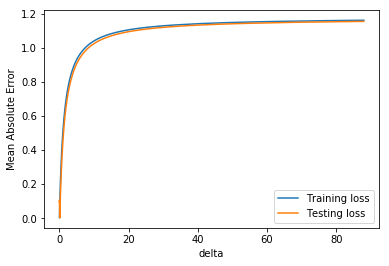

In [70]:
fig = plt.figure()
plt.plot(delta_seq, losses, label='Training loss')
plt.plot(delta_seq, losses_test, label='Testing loss')

plt.ylabel("Mean Absolute Error")
plt.xlabel("delta")
# plt.title("The changes of effects depending on delta")
plt.legend()
plt.show()
fig.savefig(ecf.FIGURE_PATH + '/mae.png')


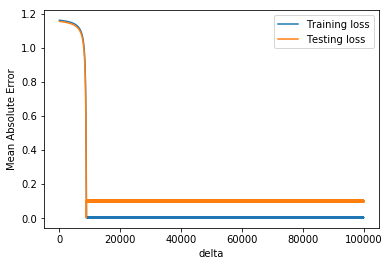

In [64]:
fig = plt.figure()
plt.plot(range(len(delta_seq)), losses, label='Training loss')
plt.plot(range(len(delta_seq)), losses_test, label='Testing loss')

plt.ylabel("Mean Absolute Error")
plt.xlabel("delta")
# plt.title("The changes of effects depending on delta")
plt.legend()
plt.show()
fig.savefig(ecf.FIGURE_PATH + '/mae.png')


## Compare with other method

### BART

In [71]:
def causal_bart(data, bart_model):
    data_pos = data.copy()
    data_pos[treatment] = 1
    data['treated_cf_outcome'] = bart_model.predict(data_pos[features])

    ## Compute counterfactual outcome with treatment
    data_neg = data.copy()
    data_neg[treatment] = 0
    data['control_cf_outcome'] = bart_model.predict(data_neg[features])
    
    return np.mean(data['treated_cf_outcome'] - data['control_cf_outcome'])

In [72]:
bart_model = SklearnModel() # Use default parameters
bart_model.fit(train[features].values, train[outcome].values)

effects_train = causal_bart(train, bart_model)
effects_test = causal_bart(test, bart_model)

mae_bart_train = utils.abs_ate(true_effect_train, effects_train)
mae_bart_test = utils.abs_ate(true_effect_test, effects_test)



OSError: [Errno 12] Cannot allocate memory

In [ ]:
print("BART on training {:.4f} an testing {:.4f}".format(mae_bart_train, mae_bart_test))

result_dic['bart_train'] = mae_bart_train
result_dic['bart_test'] = mae_bart_test

### K-nn and Linear Regression

In [ ]:
model = CausalModel(data=train,
                    treatment=treatment,
                    outcome=outcome,
                    common_causes=cov, proceed_when_unidentifiable=True)
train[treatment] = [bool(x) for x in train[treatment]]
identified_estimand = model.identify_effect()

estimate_we = model.estimate_effect(
        identified_estimand, method_name="backdoor.propensity_score_matching")

estimate_linear = model.estimate_effect(
        identified_estimand, method_name="backdoor.linear_regression")


model = CausalModel(data=test,
                    treatment=treatment,
                    outcome=outcome,
                    common_causes=cov, proceed_when_unidentifiable=True)
test[treatment] = [bool(x) for x in test[treatment]]
identified_estimand = model.identify_effect()

estimate_we_test = model.estimate_effect(
    identified_estimand, method_name="backdoor.propensity_score_matching")

estimate_linear_test = model.estimate_effect(
        identified_estimand, method_name="backdoor.linear_regression")

knn_train = utils.abs_ate(true_effect_train, estimate_we.value)
knn_test = utils.abs_ate(true_effect_test, estimate_we_test.value)

lr_train = utils.abs_ate(true_effect_train, estimate_linear.value)
lr_test = utils.abs_ate(true_effect_test, estimate_linear_test.value)

print(lr_train, lr_test)

result_dic['knn_train'] = knn_train
result_dic['knn_test'] = knn_test

result_dic['lr_train'] = lr_train
result_dic['lr_test'] = lr_test

### TMLE

In [73]:
cov, features

(['account_age',
  'age',
  'avg_hours',
  'days_visited',
  'friends_count',
  'has_membership',
  'is_US',
  'songs_purchased'],
 ['account_age',
  'age',
  'avg_hours',
  'days_visited',
  'friends_count',
  'has_membership',
  'is_US',
  'songs_purchased',
  'income',
  'treatment'])

In [74]:
train.head()

,account_age,age,avg_hours,days_visited,friends_count,has_membership,is_US,songs_purchased,income,price,...,prediction,cf1,cf0,q1,q0,ips_weight,w0,w1,a0,a1
0,4,55,2.655293,0,13,0,1,11.548132,0.886647,0.85,...,0,4.879284,7.685378,0.562623,0.437377,1.643178,0.000000,1.643178,-0.000000,-2.633281
1,3,21,7.795891,2,14,1,1,8.441743,1.880491,0.85,...,0,20.827035,21.155791,0.588804,0.411196,1.715965,0.000000,1.715965,-0.000000,-0.374756
2,1,52,9.196322,1,8,1,1,0.562812,0.443071,1.00,...,0,7.555403,10.318173,0.589627,0.410373,2.391977,2.391977,0.000000,2.669974,-0.000000
3,3,22,3.503578,6,10,1,1,6.851343,1.718376,1.00,...,0,23.689639,24.084735,0.628343,0.371657,2.182977,2.182977,0.000000,0.270126,-0.000000
4,2,19,3.389314,2,12,0,1,2.708226,2.040199,1.00,...,0,18.679879,19.003159,0.625862,0.374138,2.195593,2.195593,0.000000,0.253421,-0.000000


In [75]:
train, test = train_test_split(train_data, test_size=0.2, random_state = 1)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

expose_m = ' + '.join(cov)
outcome_m = ' + '.join(features)

model_t = LogisticRegression(penalty='l2', random_state=201)
model_y = GradientBoostingRegressor(random_state=0, n_estimators = 5000)

tml = TMLE(train, exposure=treatment, outcome=outcome)
tml.exposure_model(expose_m, bound=[0.01, 0.99], print_results=False, custom_model=model_t)
tml.outcome_model(outcome_m, print_results=False, custom_model = model_y)
tml.fit()

mae_train = utils.abs_ate(true_effect_train, tml.average_treatment_effect)

tml = TMLE(test, exposure=treatment, outcome=outcome)
tml.exposure_model(expose_m, bound=[0.01, 0.99], print_results=False, custom_model=model_t)
tml.outcome_model(outcome_m, print_results=False)
tml.fit()

mae_test = utils.abs_ate(true_effect_test, tml.average_treatment_effect)


result_dic['tmle_train'] = mae_train
result_dic['tmle_test'] = mae_test


### Causal Forest

In [76]:
cf = CausalForest(
        num_trees=50,
        split_ratio=0.5,
        min_leaf=5,
        max_depth=20,
        use_transformed_outcomes=True,
        num_workers=4,
        seed_counter=1,
    )

train['term_t'] = train[treatment].apply(lambda x: bool(x))
test['term_t'] = test[treatment].apply(lambda x: bool(x))
    
    
cf = cf.fit(train[features].values, train['term_t'].values, train[outcome].values)

cf_train = np.mean(cf.predict(train[features].values))
cf_test = np.mean(cf.predict(test[features].values))

mae_train = utils.abs_ate(true_effect_train, cf_train)
mae_test = utils.abs_ate(true_effect_test, cf_test)


OSError: [Errno 12] Cannot allocate memory

In [ ]:
result_dic['causal_forest_train'] = mae_train
result_dic['causal_forest_test'] = mae_test

### Ortho

In [ ]:
train, test = train_test_split(train_data, test_size=0.2, random_state = 1)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [ ]:
## Linear
est = LinearDRLearner(model_propensity=GradientBoostingClassifier(),
                      model_regression=GradientBoostingRegressor())
est.fit(Y = train[outcome].values, T = train[treatment].values, X = train[features].values, inference='statsmodels')
ate_dr_train = np.mean(est.effect(train[features].values))
ate_dr_test = np.mean(est.effect(test[features].values))

## Forest
est = ForestDRLearner(model_propensity=GradientBoostingClassifier(),
                  model_regression=GradientBoostingRegressor())
est.fit(Y = train[outcome].values, T = train[treatment].values, X = train[features].values, inference='blb')
ate_fdr_train = np.mean(est.effect(train[features].values))
ate_fdr_test = np.mean(est.effect(test[features].values))


est = DiscreteTreatmentOrthoForest(n_trees=500,
                               model_Y = WeightedLasso(alpha=0.5))

est.fit(Y = train[outcome].values, T = train[treatment].values, X = train[features].values, inference='blb')

ate_ortho_train = np.mean(est.effect(train[features].values))
ate_ortho_test = np.mean(est.effect(test[features].values))


ortho_train = utils.abs_ate(true_effect_train, ate_ortho_train)
dr_train = utils.abs_ate(true_effect_train, ate_dr_train)
fdr_train = utils.abs_ate(true_effect_train, ate_fdr_train)

ortho_test = utils.abs_ate(true_effect_test, ate_ortho_test)
dr_test = utils.abs_ate(true_effect_test, ate_dr_test)
fdr_test = utils.abs_ate(true_effect_test, ate_fdr_test)



In [ ]:
result_dic['ortho_train'] = ortho_train
result_dic['ortho_test'] = ortho_test

result_dic['linear_dr_train'] = dr_train
result_dic['linear_dr_test'] = dr_test

result_dic['forest_dr_train'] = fdr_train
result_dic['forest_dr_test'] = fdr_test


## Conclusion

In [ ]:
df_result = pd.DataFrame()
df_result['Method'] = ''
df_result['Training'] = ''
df_result['Testing'] = ''

results = []
results.append(['OLS', result_dic['lr_train'], result_dic['lr_test']])
results.append(['K-NN', result_dic['linear_dr_train'], result_dic['linear_dr_train']])
results.append(['BART', result_dic['bart_train'], result_dic['bart_test']])
results.append(['Causal Forest', result_dic['causal_forest_train'], result_dic['causal_forest_test']])
results.append(['Orthogonal Random Forest', result_dic['linear_dr_train'], result_dic['linear_dr_train']])
results.append(['ForestDRLearnet', result_dic['forest_dr_train'], result_dic['forest_dr_test']])
results.append(['LinearDRLearner', result_dic['linear_dr_train'], result_dic['linear_dr_test']])
results.append(['TMLE', result_dic['tmle_train'], result_dic['tmle_test']])
results.append(['Incremental Propensity Score', result_dic['incremental_train'], result_dic['incremental_test']])


In [ ]:
count = 0
for i in results:
    df_result.loc[count,'Method'] = i[0]
    df_result.loc[count,'Training'] = round(i[1],4)
    df_result.loc[count,'Testing'] = round(i[2],4)
    count +=1
